In [7]:
import pandas as pd
import wandb
import matplotlib.pyplot as plt
from copy import deepcopy
import os
import json

api = wandb.Api()
entity = "magalhaes"
project = "Audio"

runs = api.runs(f"{entity}/{project}")

In [8]:
summary_list, config_list, name_list = [], [], []
for run in runs:
    if ("Precomputed_Spec_MData" in run.name and "split" not in run.name) or ("TestingAirAbsorption" in run.name):
        # .summary contains output keys/values for
        # metrics such as accuracy.
        #  We call ._json_dict to omit large files
        summary_dict = run.summary._json_dict


        # if run is not finished, skip
        if run.state != "finished":
            continue

        # Add the run's id
        summary_dict['run_id'] = run.id
        summary_list.append(summary_dict)

        logged_artifacts = run.logged_artifacts()
        
        for artifact in logged_artifacts:
            # Check if artifact.name contains CrossValResultsTable
            # ALERT: This will not download new data if directories exist, manually delete them to refresh
            if "CrossValResultsTable" in artifact.name and "Schreder" not in artifact.name:
                    root = f"../wandb_dump_data/run-{run.name}"
                    # If the dir "root" exists, skip
                    if not os.path.isdir(root):
                        artifact.download(root=f"../wandb_dump_data/run-{run.name}")

                    # Read the json file downloaded into a dataframe
                    json_data = json.load(open(f"../wandb_dump_data/run-{run.name}/Cross Val Results Table.table.json"))

                    # Convert the json file into a dataframe
                    table_df = pd.DataFrame(json_data['data'], columns=json_data['columns'])

        # .name is the human-readable name of the run.
        name_list.append(run.name)


        # Set f1-score, accuracy, precision, recall in the summary_dict from the table_df, from the "all" class
        summary_dict['F1 score'] = table_df.loc[table_df['Class'] == 'all']['F1-score'].values[0]
        summary_dict['Precision'] = table_df.loc[table_df['Class'] == 'all']['Precision'].values[0]
        summary_dict['Recall'] = table_df.loc[table_df['Class'] == 'all']['Recall'].values[0]


summary_df = pd.DataFrame.from_records(summary_list)

summary_df['name'] = name_list

# Remove the rows with no "Cross Val Results Table"
summary_df = summary_df[summary_df['Cross Val Results Table'].notna()]


# FIlter summary_df to only include rows with "name" containing "MData" and NOT containing "split"
summary_df = summary_df[summary_df['name'].str.contains("MData") & ~summary_df['name'].str.contains("split")]

# Remove "Precomputed_Spec_MData_" from "name" column
summary_df['name'] = summary_df['name'].str.replace("Precomputed_Spec_MData_", "")

# Separate the "name" into "Augmentation" and "RunID" where the "name" is NameOfAugmentationRunID, but RunID is a number. Eg AddGaussianNoise0
summary_df[['Augmentation', 'RunID']] = summary_df['name'].str.split('(?<=\D)(?=\d)', expand=True)

# # Remove the "name" column
# summary_df = summary_df.drop(columns=['name'])

# Reduce columns to "Name", "Recall", "F1 score", "Precision", "Accuracy"
summary_df = summary_df[["Augmentation", "RunID", "F1 score", "Recall", "Precision", "Accuracy"]]

# Sort by augmentation
summary_df = summary_df.sort_values(by=['Augmentation'], ascending=False)

# # Sort by augmentation, then by f1-score
# # summary_df = summary_df.sort_values(by=['Augmentation', 'F1 score'], ascending=False)

# Rename f1 score to F1Score
summary_df = summary_df.rename(columns={"F1 score": "F1-Score"})

# Remove the ids
summary_df = summary_df.reset_index(drop=True)

summary_df.to_csv("wandb_query.csv", index=False)

In [9]:
df = summary_df

# Calculate the difference in F1-Score compared to Base 0
base_f1_score = df[df["Augmentation"] == "Base"]["F1-Score"].values[0]
print(f"Base F1-Score: {base_f1_score}")

# Find the entry for Gain and RunID None
gain_f1_score = df[(df["Augmentation"] == "Gain") & (df["RunID"].isna())]["F1-Score"].values[0]

df["Difference"] = (df["F1-Score"] - base_f1_score) * 100

# Filter out rows with NaN values in the F1-Score
df = df[(df["Augmentation"] != "Base") & ~df["F1-Score"].isna()]

Base F1-Score: 0.563662847198044


/tmp/ipykernel_10512/1060520073.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(df["RunID"].unique()))  # Use a different colormap


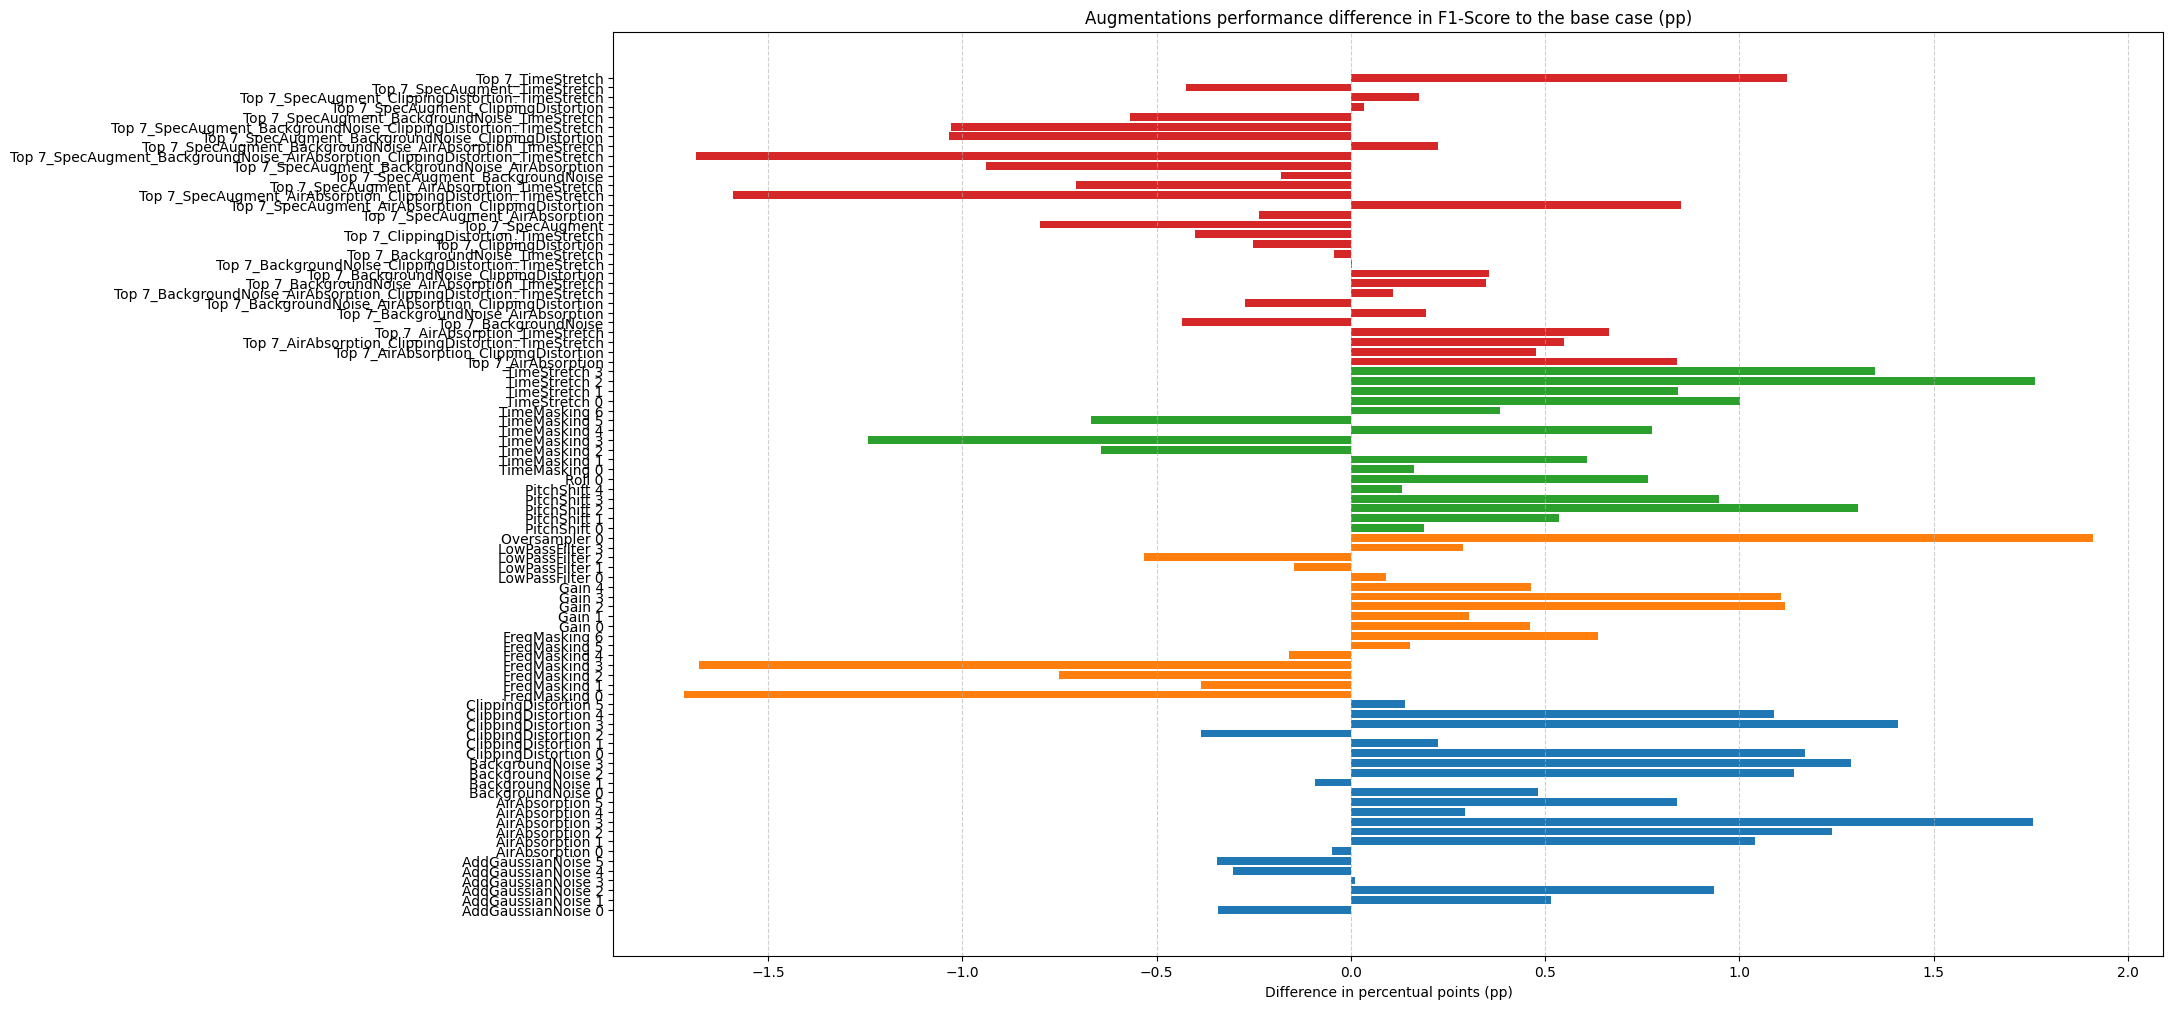

In [10]:
# Create a horizontal bar chart for each augmentation type
plt.figure(figsize=(20, 12))
colors = plt.cm.get_cmap("tab10", len(df["RunID"].unique()))  # Use a different colormap

# Sort them alphabetically, then by runid
my_df = deepcopy(df.sort_values(by=["Augmentation", "RunID"]))

# Only plot the ones with "RunID" not none
my_df = my_df[my_df["RunID"].isna() == False]

for i, (augmentation, group) in enumerate(my_df.groupby("Augmentation")):
    color = colors(i % len(my_df["RunID"].unique()))  # Cycle through colors
    plt.barh([augmentation + f" {run_id}" for run_id in group["RunID"]], group["Difference"], color=color, label=augmentation)

# Lower the y-axis label font size
plt.yticks(fontsize=10)

plt.xlabel('Difference in percentual points (pp)')
plt.title('Augmentations performance difference in F1-Score to the base case (pp)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.legend()

plt.show()

/tmp/ipykernel_10512/1066190524.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(df["RunID"].unique()))  # Use a different colormap


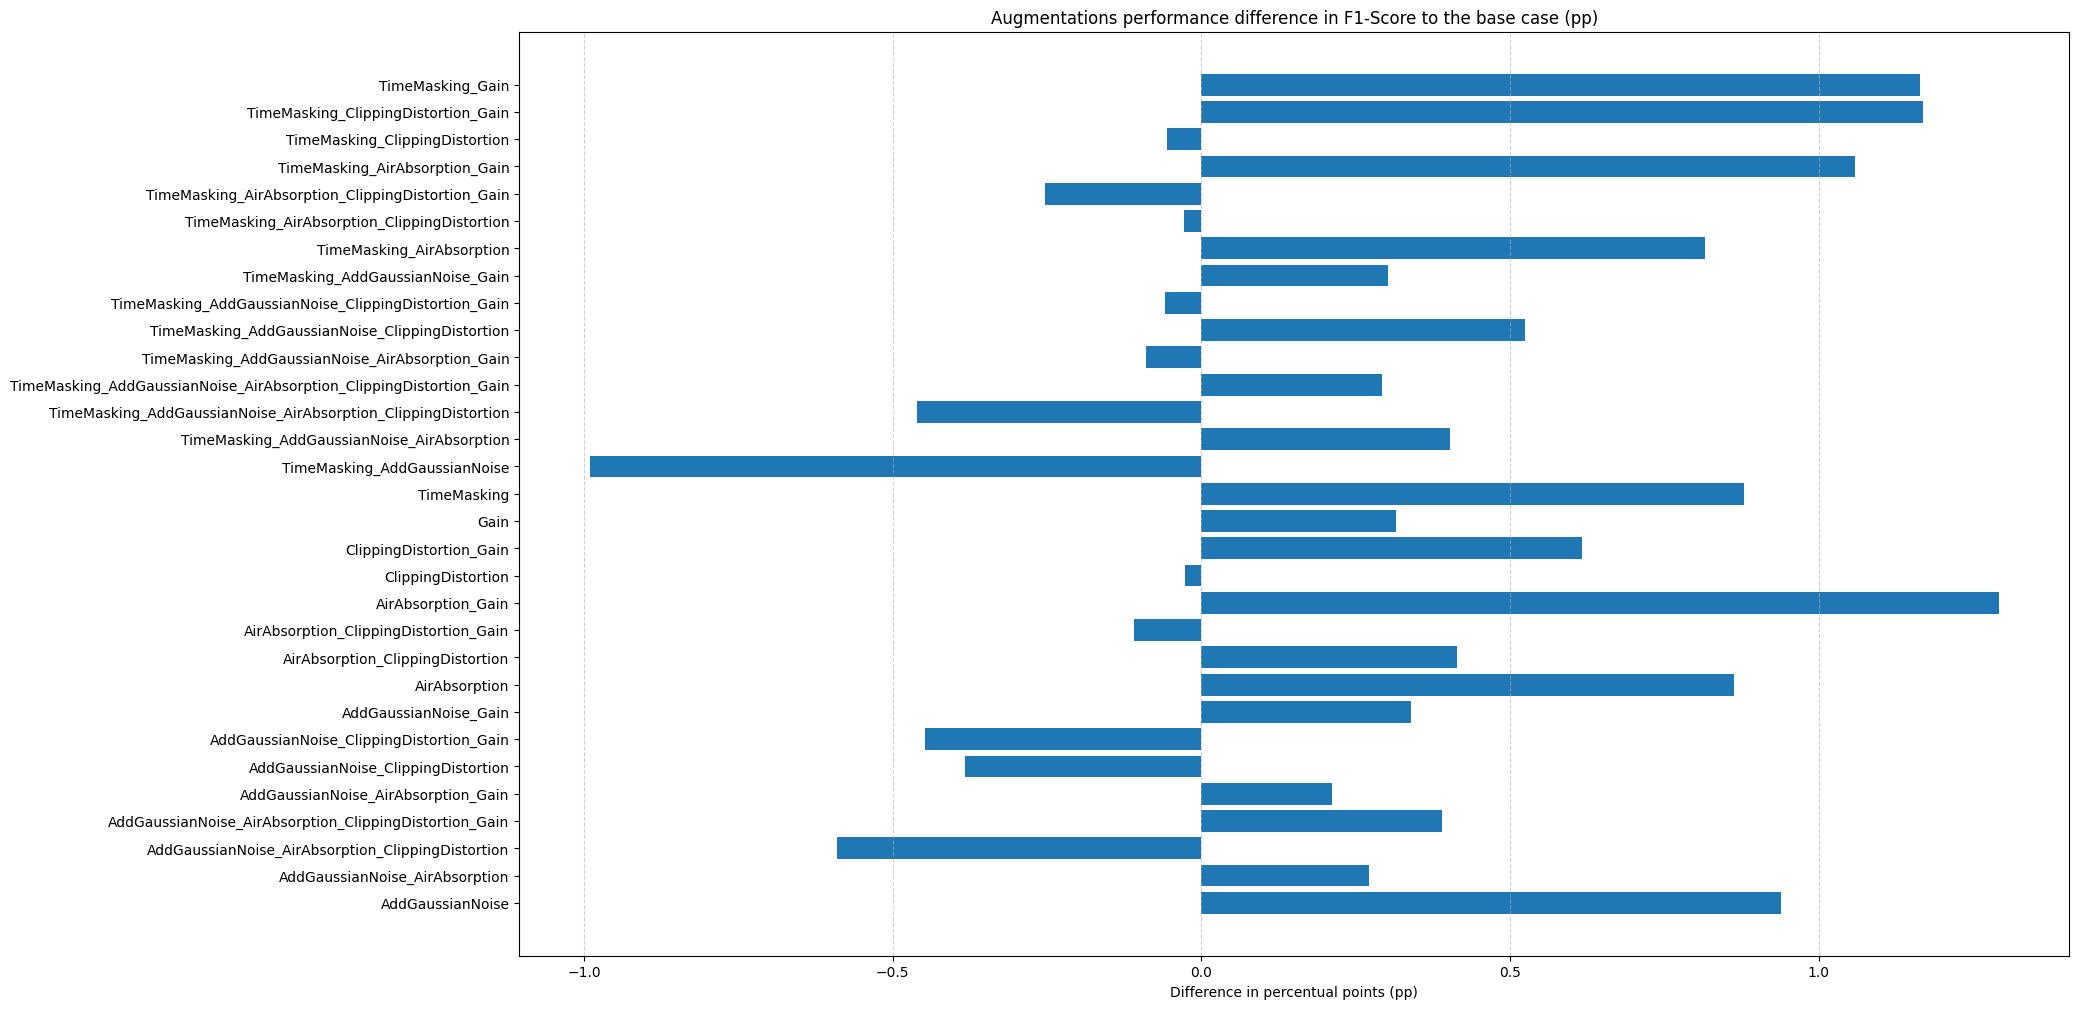

In [11]:
# Do the same as above but for the ones with "RunID" None
plt.figure(figsize=(20, 12))
colors = plt.cm.get_cmap("tab10", len(df["RunID"].unique()))  # Use a different colormap

# Sort them alphabetically, then by runid
my_df = deepcopy(df.sort_values(by=["Augmentation", "RunID"]))

# Get the best entry by F1-score
best = my_df.sort_values(by=["Augmentation", "F1-Score"], ascending=False).groupby("Augmentation").head(1)

# Only plot the ones with "RunID" not none
my_df = my_df[my_df["RunID"].isna()]

for i, (augmentation, group) in enumerate(my_df.groupby("Augmentation")):
    color = colors(i % len(my_df["RunID"].unique()))  # Cycle through colors
    plt.barh([augmentation], group["Difference"], color=color, label=augmentation)

# Lower the y-axis label font size
plt.yticks(fontsize=10)

plt.xlabel('Difference in percentual points (pp)')
plt.title('Augmentations performance difference in F1-Score to the base case (pp)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.legend()

plt.show()

In [12]:
#Get the 5 best performing augmentations, one per type
best_augmentations = []
for augmentation, group in df.groupby("Augmentation"):
    best_augmentations.append(group.sort_values(by="Difference", ascending=False).iloc[0])

# SOrt by difference
best_augmentations = sorted(best_augmentations, key=lambda x: x["Difference"], reverse=True)

# Print the best augmentations
print("Best augmentations:")
for augmentation in best_augmentations:
    print(f"{augmentation['Augmentation']} {augmentation['RunID']} with a difference of {augmentation['Difference']}pp")

Best augmentations:
Oversampler 0 with a difference of 1.9099694024237612pp
TimeStretch 2 with a difference of 1.7601795235149043pp
AirAbsorption 3 with a difference of 1.7560622702982087pp
ClippingDistortion 3 with a difference of 1.4084178216503984pp
PitchShift 2 with a difference of 1.3038537296208297pp
AirAbsorption_Gain None with a difference of 1.2921336129155803pp
BackgroundNoise 3 with a difference of 1.287202775977847pp
TimeMasking_ClippingDistortion_Gain None with a difference of 1.1687095509195222pp
TimeMasking_Gain None with a difference of 1.163988160486662pp
Top 7_TimeStretch with a difference of 1.1225018026099098pp
Gain 2 with a difference of 1.1162747481869184pp
TimeMasking_AirAbsorption_Gain None with a difference of 1.0586679006393762pp
AddGaussianNoise None with a difference of 0.9398197751327331pp
TimeMasking None with a difference of 0.8792146094695585pp
TimeMasking_AirAbsorption None with a difference of 0.816659969911604pp
Roll 0 with a difference of 0.765719969